# Building a neural network in Keras with Tensorflow

### A walkthrough for the Stockholm Machine Learning Club


<p><img style='float: right' margin='50px' src="./extra_images/keras-logo-200.png" width='150px' /></p>

<p>This notebook demonstrates how to build a simple neural network using Keras, a popular open source neural network package, and shows some of the most useful features of Keras along the way.</p>
<p><img style='float: right' margin='50px' src="./extra_images/TF-logo-200.png" width='165px' /> </p>
<p>This demonstration uses images of numerical digits expressed in sign language, collected by Turkey Ankara Ayrancı Anadolu High School Students (for more information see <a href="https://www.kaggle.com/ardamavi/sign-language-digits-dataset">kaggle.com/ardamavi/sign-language-digits-dataset</a> and <a href="https://github.com/ardamavi/Sign-Language-Digits-Dataset">github.com/ardamavi/Sign-Language-Digits-Dataset</a>). </p>


## To follow along:
If you want to follow along on your own machine then please complete the setup steps below to install everything you need. You can get the data from my github repo (https://github.com/jo-gay/keras_demo) or the original from Kaggle (link above). The data is in npy format which is easy to load using numpy.

### Set up your python environment:
<b>Warning: Keras and Tensorflow have a lot of dependencies - it will take a while to install them all.</b>

The code given assumes you are using **conda**. If not, please see below!
- Clone the repo above and navigate into the directory
- Create a new python 3.6 environment with the packages needed (<code>conda create -c anaconda -n keras_demo python=3.6 numpy=1.16 tensorflow=1.13 keras=2.2.4 matplotlib jupyter nb_conda pillow</code>)

If you don't use conda then you need to install
- tensorflow
- keras
- pillow
- matplotlib
- jupyter

The exact versions shouldn't matter, but depending on the combination of versions of keras, tensorflow and numpy, you may see various warnings in the notebook and / or in your shell. It should still work fine.

Then you will be able to run the jupyter notebook (type <code>jupyter notebook</code> to start the jupyter server (which will open a browser window), and open this file "Keras demo.ipynb".

### Preliminaries: imports and paths

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from keras import models
from keras import layers
from keras import regularizers
from keras import callbacks


C:\Users\Jo\Anaconda3\envs\keras_demo\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
%matplotlib inline
np.random.seed(20200129)
#tf.random.set_seed(20200129) # tensorflow 2
tf.set_random_seed(20200129) # tenorflow 1.13
data_path = "./Sign-language-digits-dataset/"

## Part 1: Data preparation

### Read the data (X) and labels (y)
Also check how many images we have, and what size they are.

In [6]:
X = np.load(os.path.join(data_path, 'X.npy'))
y = np.load(os.path.join(data_path, 'Y.npy'))

samples, im_width, im_height = X.shape
_, num_classes = y.shape
print(f"Loaded {samples} images of size {im_width} x {im_height}, labelled with {num_classes} classes")

Loaded 2062 images of size 64 x 64, labelled with 10 classes


### Inspect the data

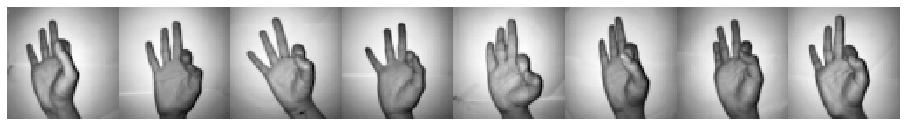

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.hstack([X[i] for i in range(8)]), cmap='gray')
plt.axis('off');

<em> Note to self: order of data is not random! All these images are of the digit nine.</em>

<em> Also: class index does not correspond to digit being shown </em>

In [8]:
class_to_digit_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

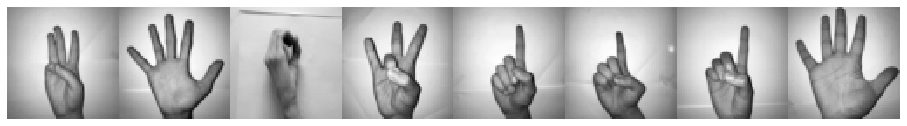

       6              5              0              7              1              1              1              5       


In [9]:
examples = np.random.choice(samples, 8)
plt.figure(figsize=(16,6))
plt.imshow(np.hstack([X[i] for i in examples]), cmap='gray')
plt.axis('off')
plt.show()
print(''.join(['{:^15d}'.format(class_to_digit_map[np.argmax(y[i])]) for i in examples]))

### Randomly select training, validation and test datasets

In [10]:
random_idxs = np.random.permutation(samples) # all the indices in a random order
m = int(samples * 0.6)
test_size = (samples - m) // 2
X_train, y_train = X[random_idxs[:m]], y[random_idxs[:m]]
X_validate, y_validate = X[random_idxs[m:(m + test_size)]], y[random_idxs[m:(m + test_size)]]
X_test, y_test = X[random_idxs[-test_size:]], y[random_idxs[-test_size:]]
# Check we have a reasonable number of examples of each class in each set
sum(y_train), sum(y_validate), sum(y_test)

(array([127., 126., 125., 128., 122., 129., 112., 126., 118., 124.]),
 array([37., 35., 47., 52., 44., 30., 52., 42., 37., 36.]),
 array([40., 44., 33., 27., 40., 49., 43., 38., 51., 47.]))

## Part 2: Build a neural network with Keras

Now that we have our training, validation and test sets, with the associated labels, we can train a neural network.

In [11]:
## Create the model and add some layers
model = models.Sequential()

# First (hidden) layer includes the dimension of the training feature vectors (N)
# The input layer is automatically added.
model.add(layers.Dense(32, input_dim=im_width*im_height, activation='relu'))

## Optional additional layers
# Standard fully connected layer
model.add(layers.Dense(32, activation='relu'))
# ... can add more layers here... see later.

# Output layer has 10 elements (one for each class, multi-class logistic regression) and uses softmax activation
model.add(layers.Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
## Compile the model, choosing optimizer, loss function (e.g. mean squared error for regression), 
#  and metrics that we want to keep track of.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                131104    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 132,490
Trainable params: 132,490
Non-trainable params: 0
_________________________________________________________________


In [13]:
X_train_flattened = np.reshape(X_train, (-1, im_width*im_height))
X_validate_flattened = np.reshape(X_validate, (-1, im_width*im_height))

In [14]:
## Run the training process, specifying how many epochs to train for
model.fit(X_train_flattened, y_train, epochs=150)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
1237/1237 [==============================] - 0s 274us/step - loss: 2.3364 - acc: 0.1156
Epoch 2/150
1237/1237 [==============================] - 0s 94us/step - loss: 2.2783 - acc: 0.1310
Epoch 3/150
1237/1237 [==============================] - 0s 98us/step - loss: 2.2415 - acc: 0.1552
Epoch 4/150
1237/1237 [==============================] - 0s 93us/step - loss: 2.1950 - acc: 0.1795
Epoch 5/150
1237/1237 [==============================] - 0s 96us/step - loss: 2.1476 - acc: 0.2013
Epoch 6/150
1237/1237 [==============================] - 0s 102us/step - loss: 2.0576 - acc: 0.2571
Epoch 7/150
1237/1237 [==============================] - 0s 105us/step - loss: 2.0277 - acc: 0.2595
Epoch 8/150
1237/1237 [==============================] - 0s 97us/step - loss: 1.9901 - acc: 0.2805
Epoch 9/150
1237/1237 [==============================] - 0s 102us/step - loss: 1.9284 - acc: 0.2967
Epoch 10/150
1237/1237 [==============================] -

1237/1237 [==============================] - 0s 83us/step - loss: 0.9783 - acc: 0.6403
Epoch 81/150
1237/1237 [==============================] - 0s 81us/step - loss: 1.0162 - acc: 0.6200
Epoch 82/150
1237/1237 [==============================] - 0s 81us/step - loss: 1.0866 - acc: 0.5837
Epoch 83/150
1237/1237 [==============================] - 0s 85us/step - loss: 1.0644 - acc: 0.5974
Epoch 84/150
1237/1237 [==============================] - 0s 91us/step - loss: 0.9375 - acc: 0.6572
Epoch 85/150
1237/1237 [==============================] - 0s 82us/step - loss: 0.9260 - acc: 0.6572
Epoch 86/150
1237/1237 [==============================] - 0s 85us/step - loss: 0.9097 - acc: 0.6661
Epoch 87/150
1237/1237 [==============================] - 0s 82us/step - loss: 0.8928 - acc: 0.6807
Epoch 88/150
1237/1237 [==============================] - 0s 83us/step - loss: 0.9058 - acc: 0.6677
Epoch 89/150
1237/1237 [==============================] - 0s 86us/step - loss: 0.9619 - acc: 0.6467
Epoch 90/150


In [15]:
model.evaluate(X_validate_flattened, y_validate)

412/412 [==============================] - 0s 111us/step


[1.2451747823687433, 0.6140776710602843]

In [16]:
val_predictions = model.predict(X_validate_flattened)

In [17]:
sum(np.argmax(val_predictions, axis=1) == np.argmax(y_validate, axis=1))

253

#### <i>Note: The outcome of the above training is highly variable depending on whether you got lucky with initial weights</i>

### Try slightly bigger model
We didn't get a very good accuracy level on the training data, so let's try adding more layers. Since we already seem to be slightly overfitting, let's also add some dropout layers

In [18]:
## Create the model and add some layers
model = models.Sequential()

# First (hidden) layer includes the dimension of the training feature vectors (N)
# The input layer is automatically added.
model.add(layers.Dense(128, input_dim=im_width*im_height, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.25))

# Output layer with one node for each output class
model.add(layers.Dense(num_classes, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
## Compile the model, choosing optimizer, loss function (e.g. mean squared error for regression), 
#  and metrics that we want to keep track of.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total para

In [20]:
# Run the training process. Here we specify the mini-batch size as 128 (default 32). 
# This affects how many parameter updates there are in each epoch and therefore how smoothly the weights are tuned
model.fit(X_train_flattened, y_train, epochs=200, batch_size=128)

Epoch 1/200
1237/1237 [==============================] - 1s 461us/step - loss: 2.3780 - acc: 0.0994
Epoch 2/200
1237/1237 [==============================] - 0s 131us/step - loss: 2.3158 - acc: 0.1164
Epoch 3/200
1237/1237 [==============================] - 0s 133us/step - loss: 2.3127 - acc: 0.1075
Epoch 4/200
1237/1237 [==============================] - 0s 132us/step - loss: 2.2750 - acc: 0.1455
Epoch 5/200
1237/1237 [==============================] - 0s 145us/step - loss: 2.2287 - acc: 0.1819
Epoch 6/200
1237/1237 [==============================] - 0s 148us/step - loss: 2.1890 - acc: 0.1867
Epoch 7/200
1237/1237 [==============================] - 0s 131us/step - loss: 2.0872 - acc: 0.2215
Epoch 8/200
1237/1237 [==============================] - 0s 127us/step - loss: 2.0463 - acc: 0.2288
Epoch 9/200
1237/1237 [==============================] - 0s 129us/step - loss: 1.9545 - acc: 0.2377
Epoch 10/200
1237/1237 [==============================] - 0s 131us/step - loss: 1.8873 - acc: 0.2611

1237/1237 [==============================] - 0s 138us/step - loss: 0.5469 - acc: 0.8173
Epoch 82/200
1237/1237 [==============================] - 0s 135us/step - loss: 0.5382 - acc: 0.8262
Epoch 83/200
1237/1237 [==============================] - 0s 127us/step - loss: 0.5594 - acc: 0.7922
Epoch 84/200
1237/1237 [==============================] - 0s 127us/step - loss: 0.5557 - acc: 0.8084
Epoch 85/200
1237/1237 [==============================] - 0s 132us/step - loss: 0.6222 - acc: 0.8003
Epoch 86/200
1237/1237 [==============================] - 0s 139us/step - loss: 0.5283 - acc: 0.8270
Epoch 87/200
1237/1237 [==============================] - 0s 131us/step - loss: 0.5342 - acc: 0.8238
Epoch 88/200
1237/1237 [==============================] - 0s 128us/step - loss: 0.6122 - acc: 0.7898
Epoch 89/200
1237/1237 [==============================] - 0s 138us/step - loss: 0.7439 - acc: 0.7324
Epoch 90/200
1237/1237 [==============================] - 0s 130us/step - loss: 0.6490 - acc: 0.7728
Epo

1237/1237 [==============================] - 0s 129us/step - loss: 0.3370 - acc: 0.8860
Epoch 162/200
1237/1237 [==============================] - 0s 130us/step - loss: 0.3718 - acc: 0.8682
Epoch 163/200
1237/1237 [==============================] - 0s 127us/step - loss: 0.3798 - acc: 0.8682
Epoch 164/200
1237/1237 [==============================] - 0s 127us/step - loss: 0.4382 - acc: 0.8343
Epoch 165/200
1237/1237 [==============================] - 0s 131us/step - loss: 0.3666 - acc: 0.8707
Epoch 166/200
1237/1237 [==============================] - 0s 126us/step - loss: 0.3015 - acc: 0.9062
Epoch 167/200
1237/1237 [==============================] - 0s 127us/step - loss: 0.2697 - acc: 0.9184
Epoch 168/200
1237/1237 [==============================] - 0s 127us/step - loss: 0.2711 - acc: 0.9119
Epoch 169/200
1237/1237 [==============================] - 0s 129us/step - loss: 0.2513 - acc: 0.9167
Epoch 170/200
1237/1237 [==============================] - 0s 126us/step - loss: 0.2309 - acc: 0

In [21]:
model.evaluate(X_validate_flattened, y_validate)

412/412 [==============================] - 0s 247us/step


[1.4329548547568831, 0.6771844677554751]

### Use a CNN instead
A basic neural network like the ones above is not ideal for image data because it treats each pixel as an independent feature. We do not want to throw away all of the spatial information, so let's try building a CNN instead.

<em>This section uses the alternative 'functional' syntax of Keras instead of the Sequential() model above</em>

In [22]:
input_layer = layers.Input(shape=(im_width,im_height,1))
hidden_layers = layers.Conv2D(16, kernel_size=(3,3), activation='relu')(input_layer)
hidden_layers = layers.Conv2D(16, kernel_size=(3,3), activation='relu')(hidden_layers)
hidden_layers = layers.Flatten()(hidden_layers)
output_layer = layers.Dense(10, activation='softmax')(hidden_layers)
model = models.Model(inputs=input_layer, outputs=output_layer)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                576010    
Total params: 578,490
Trainable params: 578,490
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Instead of flattening the data we now need to expand the dimensions. 
# Convert to the 'channels last' format expected by tensorflow 
X_train_cnn = np.reshape(X_train, (-1, im_width, im_height, 1))
X_validate_cnn = np.reshape(X_validate, (-1, im_width, im_height, 1))
X_train_cnn.shape

(1237, 64, 64, 1)

In [25]:
## Run the training process
model.fit(X_train_cnn, y_train, epochs=20)

Epoch 1/20
1237/1237 [==============================] - 5s 4ms/step - loss: 2.1183 - acc: 0.3129
Epoch 2/20
1237/1237 [==============================] - 5s 4ms/step - loss: 0.9707 - acc: 0.7429
Epoch 3/20
1237/1237 [==============================] - 4s 4ms/step - loss: 0.5266 - acc: 0.8399
Epoch 4/20
1237/1237 [==============================] - 5s 4ms/step - loss: 0.3386 - acc: 0.9006
Epoch 5/20
1237/1237 [==============================] - 5s 4ms/step - loss: 0.2162 - acc: 0.9361
Epoch 6/20
1237/1237 [==============================] - 4s 4ms/step - loss: 0.1183 - acc: 0.9749
Epoch 7/20
1237/1237 [==============================] - 4s 4ms/step - loss: 0.0807 - acc: 0.9822
Epoch 8/20
1237/1237 [==============================] - 4s 4ms/step - loss: 0.0504 - acc: 0.9943
Epoch 9/20
1237/1237 [==============================] - 5s 4ms/step - loss: 0.0291 - acc: 0.9984
Epoch 10/20
1237/1237 [==============================] - 5s 4ms/step - loss: 0.0190 - acc: 0.9992
Epoch 11/20
1237/1237 [======

In [26]:
model.evaluate(X_validate_cnn, y_validate)

412/412 [==============================] - 1s 2ms/step


[0.9906530142987816, 0.7839805831029577]

#### <i>Note: The results of the above training are very reliable. Unlike the fully connected network above, the CNN gets to 100% accuracy (on this dataset) every time </i>

### Add some regularization
The same CNN architecture as above except now we add a dropout layer after each convolutional layer to reduce overfitting

In [27]:
input_layer = layers.Input(shape=(im_width,im_height,1))
hidden_layers = layers.Conv2D(16, kernel_size=(3,3), activation='relu')(input_layer)
hidden_layers = layers.Dropout(rate=0.25)(hidden_layers)
hidden_layers = layers.Conv2D(16, kernel_size=(3,3), activation='relu')(hidden_layers)
hidden_layers = layers.Dropout(rate=0.25)(hidden_layers)
hidden_layers = layers.Flatten()(hidden_layers)
output_layer = layers.Dense(10, activation='softmax')(hidden_layers)
model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 16)        160       
_________________________________________________________________
dropout_3 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 60, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                576010    
Total para

If a validation set is supplied, keras can monitor the loss function and accuracy on that as well. It can also automatically take a portion of your training dataset as a validation set - use the argument <code>validation_split=0.2</code> for example.

In [28]:
model.fit(X_train_cnn, y_train, epochs=50, validation_data=(X_validate_cnn, y_validate))

Train on 1237 samples, validate on 412 samples
Epoch 1/50
1237/1237 [==============================] - 8s 7ms/step - loss: 2.4990 - acc: 0.1172 - val_loss: 2.3022 - val_acc: 0.1578
Epoch 2/50
1237/1237 [==============================] - 7s 6ms/step - loss: 2.2409 - acc: 0.2110 - val_loss: 2.0726 - val_acc: 0.4296
Epoch 3/50
1237/1237 [==============================] - 8s 6ms/step - loss: 1.5899 - acc: 0.5182 - val_loss: 1.3285 - val_acc: 0.5607
Epoch 4/50
1237/1237 [==============================] - 7s 6ms/step - loss: 0.8852 - acc: 0.7179 - val_loss: 1.0765 - val_acc: 0.6481
Epoch 5/50
1237/1237 [==============================] - 7s 6ms/step - loss: 0.6070 - acc: 0.8141 - val_loss: 0.8954 - val_acc: 0.7039
Epoch 6/50
1237/1237 [==============================] - 8s 7ms/step - loss: 0.4063 - acc: 0.8707 - val_loss: 0.8427 - val_acc: 0.7500
Epoch 7/50
1237/1237 [==============================] - 8s 6ms/step - loss: 0.2866 - acc: 0.9135 - val_loss: 0.9459 - val_acc: 0.7112
Epoch 8/50
1237

<em> By around the 20th epoch we clearly have overfitting and we abort the training process </em>

### More regularization... and automatic early stopping
So far we have used dropout layers for regularization, but Keras offers three other types of regularization wich can be applied on a per-layer basis:

- kernel regularization (penalizes large weights)
- bias regularization (penalizes large bias)
- activity regularization (penalizes large activation function outputs (so both weights and bias should be reduced))

Here we increase the dropout rate a bit and add kernel regularization onto each layer.

In [29]:
input_layer = layers.Input(shape=(im_width,im_height,1))
hidden_layers = layers.Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.05))(input_layer)
hidden_layers = layers.Dropout(rate=0.33)(hidden_layers)
hidden_layers = layers.Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.05))(hidden_layers)
hidden_layers = layers.Dropout(rate=0.33)(hidden_layers)
hidden_layers = layers.Flatten()(hidden_layers)
output_layer = layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.05))(hidden_layers)
model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 16)        160       
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 60, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                576010    
Total para

Keras also allows us to automatically stop the training process when some condition is met, usually based on the results on the validation data. Here we will monitor the value of the loss function on the validation data, and stop when this stops decreasing. Since it can fluctuate somewhat, we can set a 'patience' level so it continues until the best value yet seen was 5 epochs previous, and then restore the weights from that point.

In [30]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_cnn, y_train, epochs=150, validation_data=(X_validate_cnn, y_validate), callbacks=[early_stopping])

Train on 1237 samples, validate on 412 samples
Epoch 1/150
1237/1237 [==============================] - 8s 6ms/step - loss: 3.7896 - acc: 0.1431 - val_loss: 3.2152 - val_acc: 0.1019
Epoch 2/150
1237/1237 [==============================] - 7s 6ms/step - loss: 2.9249 - acc: 0.1722 - val_loss: 2.7290 - val_acc: 0.2985
Epoch 3/150
1237/1237 [==============================] - 7s 6ms/step - loss: 2.6247 - acc: 0.2312 - val_loss: 2.6042 - val_acc: 0.4587
Epoch 4/150
1237/1237 [==============================] - 7s 6ms/step - loss: 2.3295 - acc: 0.3767 - val_loss: 2.2615 - val_acc: 0.4029
Epoch 5/150
1237/1237 [==============================] - 7s 6ms/step - loss: 1.8523 - acc: 0.5837 - val_loss: 1.8070 - val_acc: 0.5850
Epoch 6/150
1237/1237 [==============================] - 7s 6ms/step - loss: 1.6643 - acc: 0.6661 - val_loss: 1.7709 - val_acc: 0.6117
Epoch 7/150
1237/1237 [==============================] - 7s 6ms/step - loss: 1.6055 - acc: 0.6815 - val_loss: 1.7011 - val_acc: 0.6432
Epoch 8/

<em>Should stop after around 30-35 epochs</em>

In [31]:
model.evaluate(X_validate_cnn, y_validate)

412/412 [==============================] - 1s 1ms/step


[1.3636080408559261, 0.7208737852503952]

## Part 3: Imported architectures and transfer learning
Rather than design our own network from scratch, we can download architectures published by experts. Keras has several available for use:
- VGG
- ResNet
- Inception
- Xception
- MobileNet
- DenseNet
- NASNet

We can either download weights from Keras (or elsewhere), or we can retrain with our own data, using the same architecture. Pretrained weights are especially useful when you don't have a huge amount of training data - they have generally been trained on hundreds of thousands of images. 

### Load a pre-designed architecture
ResNet50 is a deep learning architecture published by He et al., 2015. It introduced the concept of a 'residual' connection, whereby the outputs from an earlier layer are passed into a later one, skipping some layers in between. This extracts multi-scale features from the data and can help to reduce the 'vanishing gradient' problem.

In [32]:
from keras.applications import resnet50
from keras.preprocessing import image as k_image

model = resnet50.ResNet50(weights='imagenet')

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Check whether it works on our data
The imagenet weights are based on a training set of images that are size 224 x 224 x 3. The image data was also preprocessed in some way (mean-subtraction). We need to imitate this for our data to be valid.

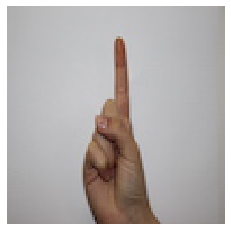

In [34]:
img_folder = 'extra_images'
img_path = os.path.join(img_folder, 'IMG_1119.jpg')
# img_path = os.path.join(img_folder, "elephant.jpg") # (image by Muhammad Mahdi Karim, cropped & resized for this demonstration)
img = k_image.load_img(img_path, target_size=(224, 224))
plt.imshow(np.asarray(img))
plt.axis('off');

In [35]:
# Preprocess image: 
# - first convert to ndarray format, 
# - then add a dimension for the image index 
#   (these methods expect to be passed a bunch of images not just one), 
# - finally apply keras preprocessing (mean subtraction)
x = k_image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = resnet50.preprocess_input(x)

In [36]:
# Image is now in the expected format for our model so let's get a prediction
preds = model.predict(x)
# convert results into a list of tuples containing (imagenet class id, description, probability)
top5_guesses = resnet50.decode_predictions(preds, top=5)[0]
# display results
print('\n'.join(["{:20s}: {:>5.2f}%".format(pred[1], pred[2]*100) for pred in top5_guesses]))

plunger             : 17.53%
Band_Aid            : 10.87%
drumstick           :  7.67%
rule                :  6.64%
wooden_spoon        :  5.70%


<em>ResNet50 with the imagenet weights didn't work for the sign language dataset, but works fine for the elephant.</em>

### Fine tuning
You can also fine-tine one of the pre-existing architectures to tailor it to your type of images and the specific image classes that you want to identify. We don't have enough data to do it properly but this shows how it might work for a bigger dataset

First we need a fudge to make our data have 3 channels instead of 1, to match the data that resnet was trained on

In [37]:
X_train_3channel = np.stack([X_train_cnn[...,0]]*3, axis=3)
X_train_3channel = resnet50.preprocess_input(X_train_3channel)
X_val_3channel = np.stack([X_validate_cnn[...,0]]*3, axis=3)
X_val_3channel = resnet50.preprocess_input(X_val_3channel)
im_shape = (im_width, im_height, 3)

In [38]:
feature_extractor = resnet50.ResNet50(weights='imagenet', input_shape=im_shape, include_top=False, pooling=None)

C:\Users\Jo\Anaconda3\envs\keras_demo\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [39]:
X_train_resnet = feature_extractor.predict(X_train_3channel)
X_validate_resnet = feature_extractor.predict(X_val_3channel)

The output from resnet is a 2x2 feature map with 2048 channels:

In [40]:
X_train_resnet.shape

(1237, 2, 2, 2048)

Use this as the input to our own classification model:

In [41]:
model = models.Sequential()
model.add(layers.Flatten()) # if pooling=None above
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
# model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.005)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [42]:
model.fit(X_train_resnet, y_train, validation_data=(X_validate_resnet, y_validate), epochs=100, verbose=2)

Train on 1237 samples, validate on 412 samples
Epoch 1/100
 - 4s - loss: 3.9778 - acc: 0.1269 - val_loss: 3.0976 - val_acc: 0.1748
Epoch 2/100
 - 2s - loss: 2.9038 - acc: 0.1956 - val_loss: 2.7403 - val_acc: 0.1529
Epoch 3/100
 - 2s - loss: 2.5498 - acc: 0.2724 - val_loss: 2.4226 - val_acc: 0.3422
Epoch 4/100
 - 2s - loss: 2.2724 - acc: 0.3719 - val_loss: 2.2333 - val_acc: 0.3981
Epoch 5/100
 - 2s - loss: 2.0974 - acc: 0.4066 - val_loss: 2.1242 - val_acc: 0.3835
Epoch 6/100
 - 2s - loss: 1.9674 - acc: 0.4325 - val_loss: 1.9321 - val_acc: 0.4563
Epoch 7/100
 - 2s - loss: 1.8060 - acc: 0.4786 - val_loss: 1.8850 - val_acc: 0.4709
Epoch 8/100
 - 2s - loss: 1.6750 - acc: 0.5392 - val_loss: 1.8598 - val_acc: 0.4393
Epoch 9/100
 - 2s - loss: 1.6171 - acc: 0.5594 - val_loss: 1.6326 - val_acc: 0.5388
Epoch 10/100
 - 2s - loss: 1.5507 - acc: 0.5772 - val_loss: 1.5581 - val_acc: 0.5874
Epoch 11/100
 - 2s - loss: 1.5172 - acc: 0.5901 - val_loss: 1.9891 - val_acc: 0.4029
Epoch 12/100
 - 2s - loss: 

Epoch 97/100
 - 2s - loss: 0.8600 - acc: 0.8424 - val_loss: 0.9825 - val_acc: 0.8010
Epoch 98/100
 - 2s - loss: 0.9245 - acc: 0.7995 - val_loss: 1.1628 - val_acc: 0.7160
Epoch 99/100
 - 2s - loss: 1.0315 - acc: 0.7583 - val_loss: 1.2608 - val_acc: 0.6748
Epoch 100/100
 - 2s - loss: 0.9335 - acc: 0.7963 - val_loss: 1.1700 - val_acc: 0.7015


In [43]:
model.evaluate(X_validate_resnet, y_validate)

412/412 [==============================] - 0s 269us/step


[1.1699615346575247, 0.7014563095222399]

### End-to-end training with a pretrained model

Instead of the two-step process above (passing data through resnet and using the result as input to our own model), an alternative is to create a combined model using a pre-trained model followed by your own layers. This is much slower to train but allows you to pick and choose which layers to train in the model.

In [44]:
input_layer = layers.Input(shape=im_shape)

Create a sequential model and add ResNet as the first layer (minus its classification layers)

In [45]:
model = models.Sequential()
model.add(resnet50.ResNet50(weights='imagenet', input_shape=im_shape, include_top=False, pooling=None))

Prevent the weights on the existing layers from being changed, except for batch normalization layers

In [46]:
bntype = type(layers.BatchNormalization())
rnlayers = model.layers[0].layers
for layer in rnlayers:
    if not isinstance(layer, bntype):
        layer.trainable=False

Add a new classification layer with the classes that we want

In [47]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

Complete the construction of our model

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                81930     
Total params: 23,669,642
Trainable params: 135,050
Non-trainable params: 23,534,592
_________________________________________________________________


In [51]:
model.fit(X_train_3channel, y_train, validation_data=(X_val_3channel, y_validate), epochs=5)

Train on 1237 samples, validate on 412 samples
Epoch 1/5
1237/1237 [==============================] - 186s 151ms/step - loss: 1.0093 - acc: 0.6799 - val_loss: 1.8720 - val_acc: 0.5607
Epoch 2/5
1237/1237 [==============================] - 182s 147ms/step - loss: 0.8508 - acc: 0.7429 - val_loss: 1.7763 - val_acc: 0.5607
Epoch 3/5
1237/1237 [==============================] - 178s 144ms/step - loss: 0.6367 - acc: 0.8068 - val_loss: 1.9410 - val_acc: 0.5728
Epoch 4/5
1237/1237 [==============================] - 184s 149ms/step - loss: 0.5894 - acc: 0.8149 - val_loss: 1.4027 - val_acc: 0.6359
Epoch 5/5
1237/1237 [==============================] - 185s 150ms/step - loss: 0.5311 - acc: 0.8270 - val_loss: 1.6886 - val_acc: 0.6553


<em>For some reason, training the top layers seems to work fine on my windows setup but not on linux, where the validation accuracy never increases :-/

In some setups the kernel crashes on this cell. It must be a particular combination of libraries but I haven't figured out what combination causes it.</em>

The training accuracy was reasonably high (and still rising), but we are still getting overfitting. We could attempt to address this with more regularization. But we may also find that these pretrained weights do not work well for grayscale images.

<em>It takes a long time to train, even when most of the weights have been fixed. On a GPU it will train a hundred or a thousand times faster. You can get GPU support in Keras by installing the GPU version of Tensorflow (tensorflow-gpu). The most recent versions of tensorflow should automatically use the GPU if available.</em>